# 🎯 Uplift model selection

#  [MegaFon Uplift Competition](https://ods.ai/competitions/megafon-df21-comp)

## problem №1: predict the uplift by user's feature vector

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_validate, GridSearchCV
from catboost import CatBoostClassifier
from sklift.models import SoloModel
from sklift.viz import plot_qini_curve

In [2]:
train = pd.read_csv('train.csv')
train.head()

,id,treatment_group,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,conversion
0,0,control,39.396577,-0.186548,19.524505,21.250208,55.291264,182.966712,-5.385606,144.573379,...,134.363458,-213.584582,-2.092461,-93.973258,-0.155597,-312.130733,44.798182,-125.682413,16.231365,0
1,1,control,38.987694,0.819522,-42.064512,-48.270949,-33.171257,179.459341,-87.151810,-162.693257,...,72.864779,559.783584,1.142391,80.037124,-1.216185,-111.473936,-127.737977,-117.501171,10.732234,0
2,2,treatment,-16.693093,1.844558,-8.615192,-18.818740,-22.271188,-116.290369,-63.816746,-38.340763,...,2.480242,96.998504,1.100962,-33.275159,0.920926,-679.492242,-91.009397,-18.173358,14.367636,0
3,3,treatment,-72.040154,-0.226921,39.802607,16.441262,-1.112509,68.128008,23.073147,4.688858,...,83.951551,-323.642557,-0.369182,93.221948,-1.962380,-442.466684,-22.298302,-75.916603,11.634299,0
4,4,treatment,18.296973,0.996437,24.465307,-34.151971,24.623458,-155.455558,-12.159787,26.705778,...,-208.531112,118.902324,-0.808578,-117.497906,1.770635,627.395611,122.019189,194.091195,-11.883858,0


In [3]:
test = pd.read_csv('test.csv')
test.head()

,id,treatment_group,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50
0,0,control,-21.671252,-0.621024,-2.842075,-51.831110,129.636266,-285.756326,-61.093746,138.041078,...,-38.413356,-24.451165,56.504067,-0.189278,10.272049,0.212921,75.886788,-110.414462,-16.709625,-0.703765
1,1,control,-34.686034,-1.151992,-22.665072,34.246181,-30.734256,-99.584956,-26.799190,-27.334872,...,-177.776349,8.018468,81.213517,-1.175417,15.345314,0.036785,205.736199,-54.989791,19.713818,-17.718764
2,2,treatment,69.048662,0.474066,9.736740,-25.494699,-9.600274,7.376884,-106.200077,39.657037,...,182.090805,-118.837053,-12.809603,0.398911,-53.774243,-0.586393,921.576204,311.032798,105.630100,0.919092
3,3,control,61.317519,1.296703,-34.345992,-17.611217,-38.021001,41.883604,-1.415220,-39.302033,...,3.848069,258.005558,-362.822718,0.660958,-138.455604,-0.904081,76.344359,57.461948,-289.542387,-37.721344
4,4,control,-76.204820,0.438070,-15.165489,-10.042479,22.548630,129.314238,71.800088,-125.207403,...,-207.931337,42.154019,-292.070142,-0.098644,66.842454,-1.072092,-1066.343927,-50.823453,-53.219431,-25.482573


### we can see that we have redundant information in the test - the fact of communication with the user. This information can't help us solve the problem of predicting the uplift, but it will help to maximize the Qini score by which the solution is estimated in this contest. Therefore:

## problem №2: use information about communication to boost Qini score (not covered in this notebook)

---

# 📝Solution to problem №1

### 1) Conditional Independence Assumption:

intuition: check if treatment was random

In [4]:
grid_search = GridSearchCV(estimator= CatBoostClassifier(random_state=42, thread_count=-1, verbose=0),
                             param_grid= {},
                             scoring= 'f1_micro', 
                             cv=3)

grid_search.fit(train.loc[:, ~train.columns.isin(['treatment_group','conversion'])], train['treatment_group'])
grid_search.best_score_

0.49986500000000006

Based on the user's features, the classifier makes type I and type II errors as often (50%) as it guesses the correct answer. This means that communication was carried out by random.

### 2) Fit single model with treatment feature (S-Learner approach) ([link to tutorial](https://habr.com/ru/company/ru_mts/blog/485980/))

intuition: the model fits simultaneously on two groups with binary treatment flag as an additional user's feature. We score each object from the test sample twice: with the treatment flag equal to 1 and equal to 0. Subtracting the probabilities for each observation, we obtain an estimated uplift.

In [5]:
from sklift.metrics import get_scorer

In [6]:
# setting up data (use test set for model evaluation after grid-search-cross-validation-tuning). Use cv set for GridSearchCV
train.treatment_group = train.treatment_group.map(lambda x: 0 if x == 'control' else (1 if x == 'treatment' else x))

stratify_cols = pd.concat([train.treatment_group, train.conversion], axis=1)

X_cv, X_test, trmnt_cv, trmnt_test, y_cv, y_test = train_test_split(
    train.drop(['treatment_group', 'conversion'],axis=1),
    train.treatment_group,
    train.conversion,
    stratify=stratify_cols,
    test_size=0.2,
    random_state=42
)

In [7]:
# setting up model ...
estimator = CatBoostClassifier(
                                random_state=42,
                                thread_count=-1,
                                verbose=False
                            )
# ... metamodel ...
slearner = SoloModel(estimator=estimator)

# ... and uplift metric scorer to pass to cross validation
uplift_scorer = get_scorer("qini_auc_score", trmnt_cv)

In [8]:
cv_gen = StratifiedShuffleSplit(
    n_splits=3,
    random_state=42
)

cross_validate(slearner,    
               X=X_cv,
               y=y_cv,
               scoring=uplift_scorer,
               return_estimator=True,
               cv=cv_gen,
               n_jobs=-1,
               fit_params={'treatment': trmnt_cv}
)

{'fit_time': array([133.37991595, 133.42379808, 133.0478034 ]),
 'score_time': array([0.10970783, 0.09973359, 0.1236701 ]),
 'estimator': [SoloModel(estimator=<catboost.core.CatBoostClassifier object at 0x000001E2CC25E880>),
  SoloModel(estimator=<catboost.core.CatBoostClassifier object at 0x000001E2CC25E130>),
  SoloModel(estimator=<catboost.core.CatBoostClassifier object at 0x000001E2804CEA60>)],
 'test_score': array([0.24533078, 0.23846022, 0.24624434])}

In [9]:
grid_search = GridSearchCV(slearner,
                           param_grid= {'estimator__learning_rate': [0.01, 0.03],
                                        'estimator__max_depth':[4,5,6]
                                        },
                           scoring= uplift_scorer,
                           n_jobs=-1,
                           cv=cv_gen)

grid_search.fit(
    X=X_cv,
    y=y_cv,
    treatment=trmnt_cv
)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=42, test_size=None,
            train_size=None),
             estimator=SoloModel(estimator=<catboost.core.CatBoostClassifier object at 0x000001E2CC286D30>),
             n_jobs=-1,
             param_grid={'estimator__learning_rate': [0.01, 0.03],
                         'estimator__max_depth': [4, 5, 6]},
             scoring=make_scorer(scorer, treatment_value=96674     1
351735    1
173777    1
405347    1
109274    0
         ..
577272    1
438763    1
157515    1
560880    1
588999    0
Name: treatment_group, Length: 480000, dtype: int64))

In [10]:
grid_search.best_params_

{'estimator__learning_rate': 0.03, 'estimator__max_depth': 6}

In [11]:
print("best qini score on grid search: ", grid_search.best_score_)

best qini score on grid search:  0.23615346047086438


In [12]:
slearner.set_params(**grid_search.best_params_)

slearner.fit(
    X=X_cv, 
    y=y_cv, 
    treatment=trmnt_cv,
)

uplift_from_slearner = slearner.predict(X_test)

<AxesSubplot:title={'center':'Qini curve\nqini_auc_score=0.2391'}, xlabel='Number targeted', ylabel='Number of incremental outcome'>

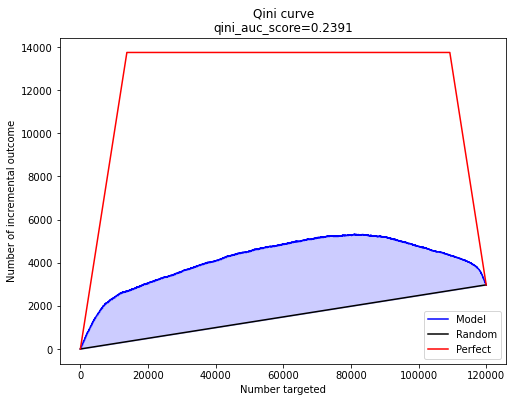

In [13]:
plot_qini_curve(y_test, uplift_from_slearner, trmnt_test, perfect=True)